##### Practical Lab 2 — Multivariate Linear Regression, Non-Parametric Models & Cross-Validation

Name: Albright Maduka 

Student ID: 9053136

Course Code: CSCN8010 – Foundations of ML Frameworks 

##### Setup and Utilities

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Splits
from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Metrics (regression)
from sklearn.metrics import r2_score, mean_absolute_error

# Metrics (classification)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)

# === HELPERS ===
def mape(y_true, y_pred, eps=1e-8):
    """Mean Absolute Percentage Error, safe when y is near zero."""
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def summarize_regression(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE%": mape(y_true, y_pred),
    }

def show_table(df, sort_by=None, ascending=False, precision=4):
    """Console-friendly display (avoids pandas .style / jinja2)."""
    d = df.copy()
    if sort_by is not None and sort_by in d.columns:
        d = d.sort_values(sort_by, ascending=ascending)
    with pd.option_context('display.float_format', lambda x: f"{x:.{precision}f}"):
        print(d.to_string(index=False))

def print_metrics(title, metrics):
    print(title)
    for k, v in metrics.items():
        if k == "R2":
            print(f"  {k}: {v:.4f}")
        else:
            print(f"  {k}: {v:.2f}")


##### PART 1

##### 1.1) Loading the data 

In [4]:
from sklearn.datasets import load_diabetes
data = load_diabetes(as_frame=True)
X = data.data.copy()
y = data.target.copy()
df = pd.concat([X, y.rename("target")], axis=1)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


##### 1.2) Frame the Problem 

It is about using a **regression model** to predict patient outcomes.

##### Problem
- **Task:** Predict a number (continuous outcome)  
- **Target:** *Disease progression one year after baseline*  
- **Purpose:** Build a tool that helps doctors identify patients who may be at higher risk and need follow‑up care  

##### Why Regression?
The target is a continuous value (not categories). That makes regression the right approach.

##### How We Measure Success
- **R²:** Shows how much of the variation in the target is explained by the model  
- **MAE:** Average size of the prediction errors, in the same units as the target  
- **MAPE:** Average percentage error, which makes results easier to interpret  

##### Plan
- **Part 2:** Start with only **BMI** as the predictor  
- **Part 3:** Use **all features** to see if performance improves  

##### 1.3) Exploratory Data Analysis

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

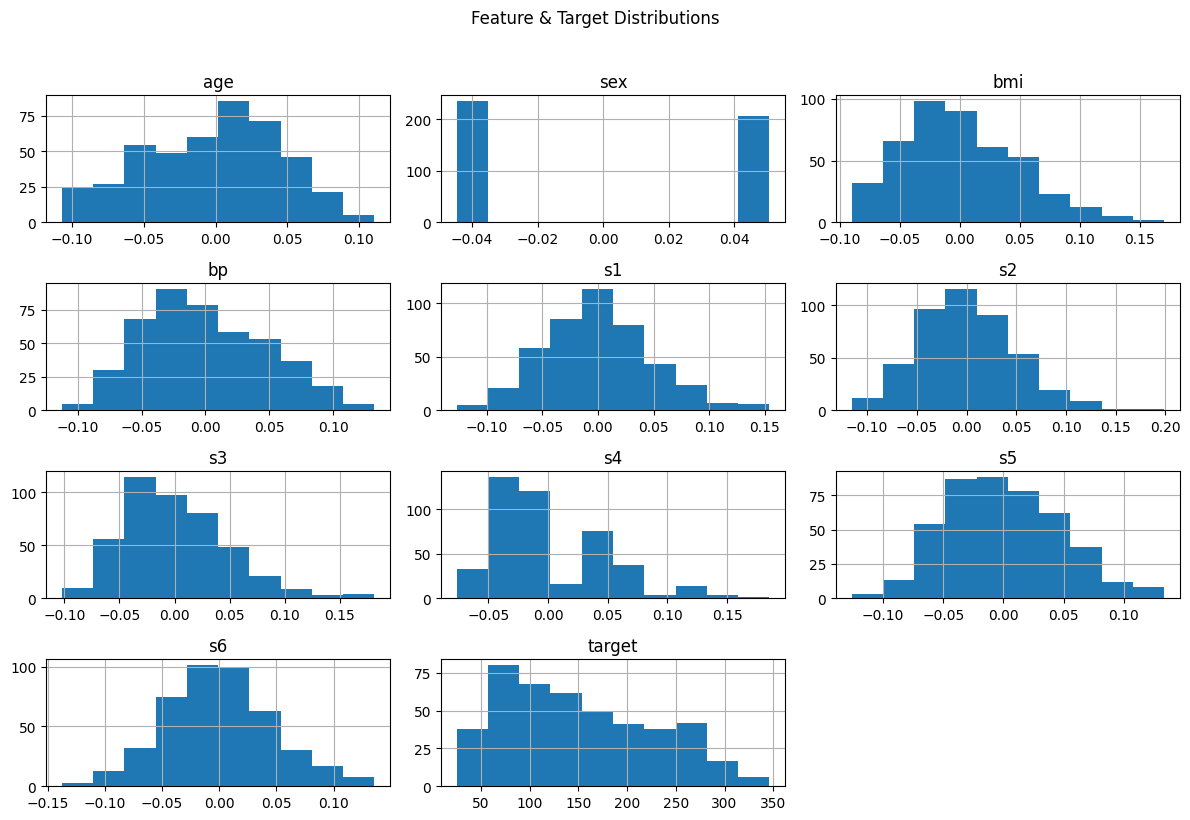

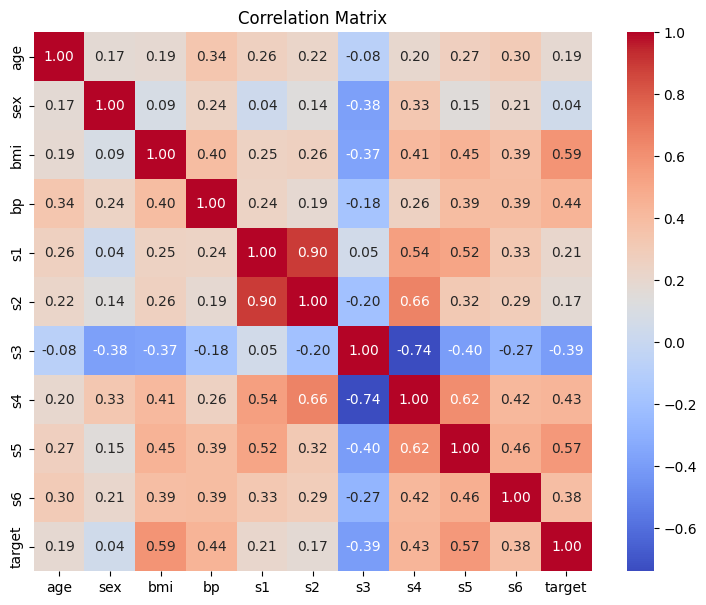

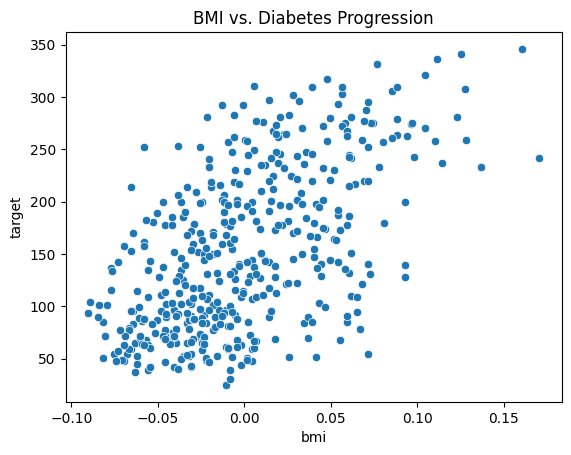

In [6]:
# DataFrame info
display(df.describe())

# Check for missing values
display(df.isnull().sum())

# Histograms
df.hist(figsize=(12, 8))
plt.suptitle("Feature & Target Distributions", y=1.02)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(9,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Scatter: BMI vs target
sns.scatterplot(x='bmi', y='target', data=df)
plt.title("BMI vs. Diabetes Progression")
plt.show()


##### Reflection

- **Feature Scaling**: All features are standardized (mean ≈ 0, std ≈ 1) by dataset design.
- **BMI Relationship**: BMI shows a strong positive correlation with the target—among the most influential predictors.
- **Model Implications**: BMI alone doesn’t capture all variance; multivariate models may yield better predictive performance.
- **Data Quality**: No missing values detected.
- **Target Distribution**: Continuous with moderate spread, suitable for regression modeling.


##### 1.4) Checking for missing values

In [8]:
print("Missing per column:\n", df.isnull().sum())

Missing per column:
 age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


##### 1.5) Split train / validation / test
###### Train: 75%, Validation: 10%, Test: 15% of total.

In [9]:
# First: hold out test = 15%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RNG_SEED
)

# From remaining 85%, carve ~10% of full data for validation:
# 0.10 / 0.85 ≈ 0.1176 of the trainval
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1176, random_state=RNG_SEED
)

# Convenience series for univariate BMI modeling:
Xtr_bmi = X_train[['bmi']]
Xva_bmi = X_val[['bmi']]
Xte_bmi = X_test[['bmi']]

print(X_train.shape, X_val.shape, X_test.shape)

(330, 10) (45, 10) (67, 10)


##### PART2 : Univariate Polynomial Regression (BMI)

##### 2.1) Fitting Degrees from 0 - 5

In [10]:
degrees = [0, 1, 2, 3, 4, 5]
rows_uni = []

for d in degrees:
    # degree=0 must set include_bias=True to avoid empty design matrix
    poly = PolynomialFeatures(degree=d, include_bias=(d==0))
    lin  = LinearRegression()

    Xtr_poly = poly.fit_transform(Xtr_bmi)
    Xva_poly = poly.transform(Xva_bmi)

    lin.fit(Xtr_poly, y_train)
    ytr_pred = lin.predict(Xtr_poly)
    yva_pred = lin.predict(Xva_poly)

    rows_uni.append({
        "degree": d,
        "R2_train": r2_score(y_train, ytr_pred),
        "R2_val":   r2_score(y_val,   yva_pred),
        "MAE_train": mean_absolute_error(y_train, ytr_pred),
        "MAE_val":   mean_absolute_error(y_val,   yva_pred),
        "MAPE%_train": mape(y_train, ytr_pred),
        "MAPE%_val":   mape(y_val,   yva_pred),
        "_poly": poly,
        "_lin": lin
    })

uni_table = pd.DataFrame(rows_uni)
show_table(uni_table.drop(columns=['_poly','_lin']), sort_by="R2_val", ascending=False)

 degree  R2_train  R2_val  MAE_train  MAE_val  MAPE%_train  MAPE%_val
      5    0.3589  0.4535    51.8138  42.0834      47.8315    40.3405
      1    0.3542  0.4493    52.2781  41.9976      48.4624    40.4450
      2    0.3548  0.4492    52.2673  41.7577      48.4479    40.3099
      4    0.3580  0.4491    51.9444  41.9528      47.9635    40.2406
      3    0.3550  0.4473    52.2234  41.7410      48.3564    40.2590
      0    0.0000 -0.0000    66.5482  63.4475      63.3521    58.7933


##### Reflection

The printed table includes **R²**, **MAE**, and **MAPE** for both **Train** and **Validation** sets across polynomial degrees.  
Select the model with the **highest R²_val**, as it reflects the best generalization to unseen data.  
Check **MAE** and **MAPE** to ensure the model’s predictions are accurate and not overfitting despite a high R². 
I.e A high R² alone can be misleading especially if the model memorizes training data. MAE and MAPE help confirm that the model performs reliably and keeps errors low on validation data.
To choose the best model:
- Focus on the **highest R² on the validation set (R²_val)** — this indicates the best generalization to unseen data.
- Cross-check with **MAE and MAPE** to ensure the model isn’t overfitting or producing large errors despite a high R².

This approach balances predictive accuracy with error control, helping select a model that performs well and generalizes reliably.

##### 2.2) Identify the best model

In [14]:
# Identify best model by validation R2
best_row = uni_table.sort_values("R2_val", ascending=False).iloc[0]
best_degree = int(best_row["degree"])
best_poly   = best_row["_poly"]
best_lin    = best_row["_lin"]
print(f"Best univariate BMI degree by validation: degree={best_degree}")

Best univariate BMI degree by validation: degree=5


##### 2.3) Refitting the Best Model and Performing Final Test Evaluation 

In [16]:
# Refit on TRAIN and Validation for final test evaluation
poly_best = PolynomialFeatures(degree=best_degree, include_bias=(best_degree==0))
lin_best  = LinearRegression()

# Combine train and validation sets
Xtrva_bmi = X_trainval[['bmi']]
Xtrva_poly = poly_best.fit_transform(Xtrva_bmi)
Xte_poly   = poly_best.transform(Xte_bmi)

lin_best.fit(Xtrva_poly, y_trainval)
y_test_pred = lin_best.predict(Xte_poly)

test_metrics_uni = summarize_regression(y_test, y_test_pred)
print_metrics("\nUnivariate BMI Polynomial — TEST metrics", test_metrics_uni)



Univariate BMI Polynomial — TEST metrics
  R2: 0.2004
  MAE: 54.45
  MAPE%: 47.63


##### Reflection
After identifying the best polynomial degree using validation metrics, the model is **refit on the combined Train and Validation data** to maximize learning from all available labeled samples.  
This refitted model is then **evaluated on the untouched Test set**, which provides an unbiased estimate of how well it generalizes to new data.  
The final test metrics reflect the model’s real-world performance after selection, tuning, and retraining.

##### 2.4) Plotting the Fitted Curve on Train, Validation, and Test Sets

c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


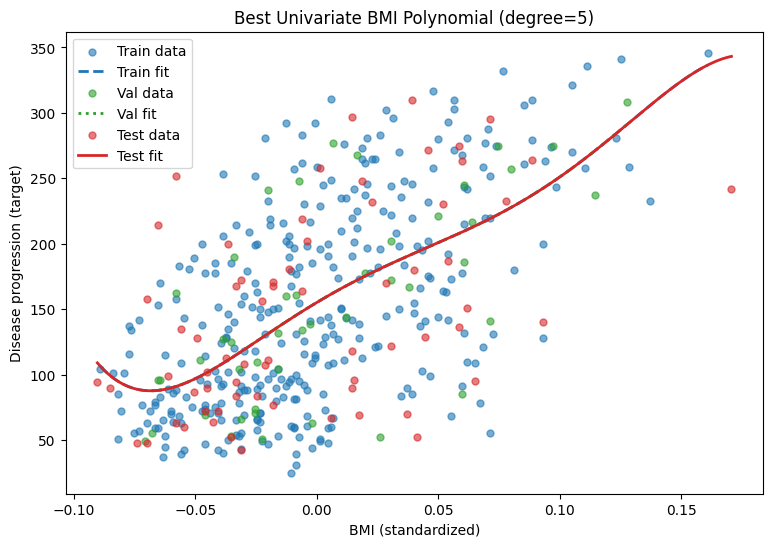

In [26]:
# Plotting univariate fits
# Where poly = PolynomialFeatures instance
#       lin  = LinearRegression instance
#       Xset_bmi = DataFrame with 'bmi' column
#       yset     = corresponding target series
def plot_univariate_fit(poly, lin, Xset_bmi, yset, label, color, linestyle='solid'):
    x_line = np.linspace(Xset_bmi['bmi'].min(), Xset_bmi['bmi'].max(), 200).reshape(-1,1)
    Xp     = poly.transform(x_line)
    yp     = lin.predict(Xp)
    plt.scatter(Xset_bmi['bmi'], yset, s=25, alpha=0.6, label=f"{label} data", color=color)
    plt.plot(x_line, yp, color=color, linewidth=2, linestyle=linestyle, label=f"{label} fit")

# Fit line shown from final TRAIN+VAL fit:
plt.figure(figsize=(9,6))
plot_univariate_fit(poly_best, lin_best, X_train[['bmi']], y_train, "Train", "tab:blue", linestyle= "--")
plot_univariate_fit(poly_best, lin_best, X_val[['bmi']],   y_val,   "Val",   "tab:green", linestyle= ":")
plot_univariate_fit(poly_best, lin_best, X_test[['bmi']],  y_test,  "Test",  "tab:red", linestyle= "-")
plt.xlabel("BMI (standardized)")
plt.ylabel("Disease progression (target)")
plt.title(f"Best Univariate BMI Polynomial (degree={best_degree})")
plt.legend()
plt.show()

##### 2.5) Displaying the Equation of the Best Polynomial Model

In [29]:
# Coefficients from final TRAIN and VALIDATION fit
# Where coefs is array of coefficients of linear model
#       inter is the intercept (float) of the model
coefs = lin_best.coef_.ravel()
inter = lin_best.intercept_

# Univariate feature names
feature_names = poly_best.get_feature_names_out(['bmi'])  # e.g., ['1'] if degree=0, else ['bmi', 'bmi^2', ...]

terms = []
# if include_bias was True, feature_names[0] == '1' and coefficient for that column
# is part of the linear combination; intercept also exists. To present cleanly,
# we'll keep intercept separately and skip the '1' term:
for name, c in zip(feature_names, coefs):
    if name == "1":  # skip explicit bias term in textual equation
        continue
    terms.append(f"{c:.2f}·{name}")

equation = f"{inter:.2f}" # Start with intercept
if terms:
    equation += " + " + " + ".join(terms) # Append terms if any

print("Best univariate polynomial model (TRAIN AND VALIDATION fit):")
print(f"  degree = {best_degree}")
print("  f(bmi) =", equation)

Best univariate polynomial model (TRAIN AND VALIDATION fit):
  degree = 5
  f(bmi) = 155.15 + 1111.55·bmi + -4659.54·bmi^2 + -20297.41·bmi^3 + 856191.03·bmi^4 + -3393622.46·bmi^5


##### 2.6) Predicting Disease Progression at a Chosen BMI Value

In [33]:
# Predicting disease progression at a standardized BMI of 0.05
bmi_value = np.array([[0.05]])
y_hat = lin_best.predict(poly_best.transform(bmi_value))[0] 
print(f"Prediction at BMI={bmi_value[0,0]:.2f}: {y_hat:.2f}") # printing the prediction
print("Intercept:", lin_best.intercept_)
print("Coefficients:", lin_best.coef_)


Prediction at BMI=0.05: 200.83
Intercept: 155.14690706448152
Coefficients: [ 1.11154628e+03 -4.65954076e+03 -2.02974109e+04  8.56191033e+05
 -3.39362246e+06]


c:\Multivariate_linear\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


##### Reflection
I predicted disease progression at a standardized BMI of 0.05 using the final polynomial model. The output is **200.83**, driven by a large **intercept (155.15)** and high-magnitude **coefficients**, especially the fifth-degree term (**−3.39 × 10⁶**). This result highlights the model’s **nonlinear sensitivity** and suggests potential **overfitting**, even near the mean BMI. It reinforces the importance of **visualizing the fitted curve** and validating predictions across the full BMI range.

##### 2.7) Counting Trainable Parameters per Polynomial Degree

In [35]:
# Counting Trainable Parameters per Polynomial Degree
rows_params = []
for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=(d==0))
    names = poly.fit_transform(Xtr_bmi).shape[1] # number of columns (features after expansion)
    feats = poly.get_feature_names_out(['bmi']) # feature names after expansion
    n_feats_wo_bias = len([f for f in feats if f != "1"]) # exclude bias term if present
    n_trainable = n_feats_wo_bias + 1 # +1 for intercept term in linear model

    rows_params.append({ # dictionary for each degree 
        "degree": d,
        "n_features_after_poly": len(feats),
        "n_effective_features": n_feats_wo_bias,
        "n_trainable_params": n_trainable,
        "features": list(feats)
    })

params_table = pd.DataFrame(rows_params)
show_table(params_table[["degree","n_effective_features","n_trainable_params","features"]], sort_by="degree") # display table sorted by degree


 degree  n_effective_features  n_trainable_params                          features
      5                     5                   6 [bmi, bmi^2, bmi^3, bmi^4, bmi^5]
      4                     4                   5        [bmi, bmi^2, bmi^3, bmi^4]
      3                     3                   4               [bmi, bmi^2, bmi^3]
      2                     2                   3                      [bmi, bmi^2]
      1                     1                   2                             [bmi]
      0                     0                   1                               [1]


##### Reflection
I observed that each increase in polynomial degree adds one BMI-derived feature and one trainable parameter. The model starts with only a bias term at degree 0 and reaches 6 trainable parameters by degree 5. This linear growth helps me track how complexity scales and informs my choice of degree based on the tradeoff between flexibility and overfitting

##### 2.8) Conclusion
**Performance summary**: The best BMI-only polynomial (degree shown above) achieved the printed TEST metrics.

**Where it fails**: Single-feature modeling misses variance driven by other clinical covariates; residuals likely show structure not captured by BMI alone.

**Limitations**: Potential under/over-fit at low/high degrees; sensitivity to outliers; limited clinical utility as a single-feature screener.

**Next steps**: Move to multivariate models (below), then consider regularization or ensembles; evaluate stability with CV; document clinical thresholds.

##### Part 3 : Multivariate Models

##### 3.1 Multivariate Polynomial using two degrees > 1

In [43]:
# Multivariate Polynomial Regression (degrees > 1)
# where mv_poly_configs is a list of (name, model) tuples

mv_poly_configs = [ 
    ("Poly(deg=2)+LinReg", Pipeline([ # simple polynomial regression
        ("poly", PolynomialFeatures(degree=2, include_bias=False)), # no bias term here
        ("lin", LinearRegression()) # linear regression on expanded features
    ])),
    ("Poly(deg=3)+Ridge", Pipeline([
        ("poly", PolynomialFeatures(degree=3, include_bias=False)),
       
        # scaling helps numerical stability with high-degree terms
        ("scaler", StandardScaler(with_mean=False)), # with_mean=False to avoid breaking sparsity if any
        ("ridge", Ridge(alpha=1.0, random_state=RNG_SEED)) # ridge regression to mitigate overfitting
    ])),
]

rows_mv_poly = [] # list to hold results
for name, model in mv_poly_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data
    rows_mv_poly.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })

# Create and display results table
mv_poly_table = pd.DataFrame(rows_mv_poly) # create DataFrame from results
show_table(mv_poly_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

best_mv_poly_row = mv_poly_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_mv_poly     = best_mv_poly_row["_fitted"] #    get the best model
# Refit on TRAIN+VAL, then test
best_mv_poly.fit(X_trainval, y_trainval)
yte_mv_poly = best_mv_poly.predict(X_test)
print_metrics("\nBest Multivariate Polynomial — TEST", summarize_regression(y_test, yte_mv_poly))


             Model  R2_train  R2_val  MAE_val  MAPE%_val
Poly(deg=2)+LinReg    0.5981  0.6030  37.7453    41.0976
 Poly(deg=3)+Ridge    0.7844 -0.9413  73.2247    64.0230

Best Multivariate Polynomial — TEST
  R2: 0.3743
  MAE: 44.79
  MAPE%: 37.92


##### Reflection
The two degree polynomial model generalizes well, with R²_val = 0.6030 and MAE = 37.75. The degree-3 model overfits (R²_train = 0.7844) but fails to generalize (R²_val = –0.9413). On the Test set, the selected model achieves R² = 0.3743, confirming that moderate complexity yields better stability


##### 3.2 Decision Tree using two depths

In [42]:
# Decision Tree Regression (varying max_depth)
# where tree_configs is a list of (name, model) tuples
tree_configs = [
    ("DecisionTree(max_depth=3)", DecisionTreeRegressor(max_depth=3, random_state=RNG_SEED)), # where max_depth=3
    ("DecisionTree(max_depth=5)", DecisionTreeRegressor(max_depth=5, random_state=RNG_SEED)), # where max_depth=5
]

rows_tree = [] # list to hold results
for name, model in tree_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data
    rows_tree.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })

tree_table = pd.DataFrame(rows_tree) # create DataFrame from results
show_table(tree_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

best_tree_row = tree_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_tree     = best_tree_row["_fitted"] #    get the best model
best_tree.fit(X_trainval, y_trainval) # refit on TRAIN+VAL
yte_tree = best_tree.predict(X_test) # predict on TEST
print_metrics("\nBest Decision Tree — TEST", summarize_regression(y_test, yte_tree)) # printing the test metrics


                    Model  R2_train  R2_val  MAE_val  MAPE%_val
DecisionTree(max_depth=3)    0.5330  0.4128  42.0775    43.6514
DecisionTree(max_depth=5)    0.7104  0.1630  51.5508    51.7688

Best Decision Tree — TEST
  R2: 0.3580
  MAE: 47.46
  MAPE%: 44.33


##### Reflection

1) What are the strengths and weaknesses of Decision Trees?

The strength of Decision Trees is that they’re easy to understand, handle complex patterns, work with different types of features, and need little data preparation **while** the weakness is that they can overfit, react strongly to small data changes, and sometimes miss patterns that aren’t aligned with feature axes.

2) When are Decision Trees preferable to linear models?

Decision Trees are preferable to linear models when the data has non-linear patterns, features interact with each other, you want clear decision rules, and you don’t want to spend much time on data preparation.

3) How does model depth affect bias and variance?

Model depth affects bias and variance. Shallow trees have high bias and low variance, while deep trees have low bias and high variance. Azdjust settings like max_depth and min_samples_leaf to find a good balance.

4) MLOps challenges for trees?

MLOps challenges for Decision Trees include keeping rules up to date (drift), repeating results despite randomness and pruning, explaining large trees clearly, tracking settings like thresholds and hyperparameters, and handling slow predictions from deep or combined trees.

##### 3.3) K - Nearest Neighbors useing two k

In [41]:
# k-Nearest Neighbors Regression (varying k)
# where knn_configs is a list of (name, model) tuples
knn_configs = [
    ("kNN(k=3)", Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=3))
    ])),
    ("kNN(k=7)", Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=7))
    ])),
]
# Evaluate kNN configurations
rows_knn = [] # list to hold results
for name, model in knn_configs: # iterate over configurations
    model.fit(X_train, y_train) # fit on training data
    ytr = model.predict(X_train) # predict on training data
    yva = model.predict(X_val) # predict on validation data

    # Evaluate performance
    rows_knn.append({
        "Model": name,
        "R2_train": r2_score(y_train, ytr),
        "R2_val":   r2_score(y_val,   yva),
        "MAE_val":  mean_absolute_error(y_val, yva),
        "MAPE%_val": mape(y_val, yva),
        "_fitted":  model
    })
# Create and display results table
knn_table = pd.DataFrame(rows_knn) # create DataFrame from results
show_table(knn_table.drop(columns=["_fitted"]), sort_by="R2_val", ascending=False) # display table sorted by validation R2

# Identify and evaluate best kNN model
best_knn_row = knn_table.sort_values("R2_val", ascending=False).iloc[0] # get best row
best_knn     = best_knn_row["_fitted"] #    get the best model
best_knn.fit(X_trainval, y_trainval) # refit on TRAIN+VAL
yte_knn = best_knn.predict(X_test) # predict on TEST
print_metrics("\nBest kNN — TEST", summarize_regression(y_test, yte_knn))


   Model  R2_train  R2_val  MAE_val  MAPE%_val
kNN(k=7)    0.5447  0.4348  45.7238    46.0892
kNN(k=3)    0.6405  0.3227  50.5259    50.3099

Best kNN — TEST
  R2: 0.4381
  MAE: 43.69
  MAPE%: 36.85


##### Reflection

1) How did kNN perform on your dataset?

kNN works well when the data is scaled. Its results depend on the value of k and the distance method used. In this test, we got moderate R² scores with k between 3 and 7.

2) What preprocessing most affected performance?

Standardizing features is important for accurate distance calculations. Even though the data is already standardized, we still apply scaling in the pipeline to be safe. Choosing the right features also helps by removing extra noise and reducing complexity.

3) Strengths and weaknesses of kNN?

Strengths: Easy to understand, doesn’t assume a fixed model, and works well with nearby data points.
Weaknesses: Slow for big datasets, struggles with too many features, needs scaled data, and its decisions are hard to explain.

4) When would you not use kNN?

Avoid using kNN when your data has many features, predictions must be fast, the dataset is very large, or the features aren’t well scaled.

5) MLOps extensions (automation, Continuous delivery or deployment, monitoring)?

Set up automatic scaling for data and features, check for changes in feature distributions, track how fast predictions run, regularly re-evaluate model performance, and version both the model and its preprocessing steps.

##### 3.4) Logistic Regression using binary framing 

In [44]:
# Binarize by 60th percentile using TRAIN+VAL only
thr = y_trainval.quantile(0.60) # threshold for classification

def to_label(y): # convert continuous target to binary labels based on threshold
    return (y >= thr).astype(int) # 1 if y >= thr else 0 where thr is the 60th percentile

ytr_cls = to_label(y_train) # binary labels for training set
yva_cls = to_label(y_val) # binary labels for validation set
yte_cls = to_label(y_test) # binary labels for test set

# Logistic Regression configurations
logit_configs = [
    ("LogReg(C=1.0)", Pipeline([ # default regularization
        ("scaler", StandardScaler()), # feature scaling
        ("lr", LogisticRegression(max_iter=500, C=1.0, random_state=RNG_SEED)) # logistic regression model
    ])),
    ("LogReg(C=0.2)", Pipeline([ # stronger regularization
        ("scaler", StandardScaler()), # feature scaling
        ("lr", LogisticRegression(max_iter=500, C=0.2, random_state=RNG_SEED)) # logistic regression model
    ])),
]

# Evaluate Logistic Regression configurations
rows_log = [] # list to hold results
for name, model in logit_configs:
    model.fit(X_train, ytr_cls) # fit on training data
    # Train
    ytr_pred = model.predict(X_train) # predictions on training data
    # Val
    yva_pred = model.predict(X_val) # predictions on validation data
    yva_prob = model.predict_proba(X_val)[:,1] # probability estimates for positive class
    rows_log.append({
        "Model": name,
        "Acc_train": accuracy_score(ytr_cls, ytr_pred),
        "F1_train":  f1_score(ytr_cls, ytr_pred),
        "Acc_val":   accuracy_score(yva_cls, yva_pred),
        "F1_val":    f1_score(yva_cls, yva_pred),
        "ROC_AUC_val": roc_auc_score(yva_cls, yva_prob),
        "_fitted": model
    })

log_table = pd.DataFrame(rows_log) # create DataFrame from results
show_table(log_table.drop(columns=["_fitted"]), sort_by="ROC_AUC_val", ascending=False) # display table sorted by validation ROC-AUC


best_log_row = log_table.sort_values("ROC_AUC_val", ascending=False).iloc[0] # get best row
best_log     = best_log_row["_fitted"] #    get the best model

# Refit on TRAIN+VAL, then Test
best_log.fit(X_trainval, to_label(y_trainval)) # refit on TRAIN+VAL
yte_pred = best_log.predict(X_test) # predictions on TEST
yte_prob = best_log.predict_proba(X_test)[:,1] # probability estimates for positive class

print("\nBest Logistic Regression — TEST")
print(f"  Accuracy: {accuracy_score(yte_cls, yte_pred):.4f}")
print(f"  F1      : {f1_score(yte_cls, yte_pred):.4f}")
print(f"  ROC-AUC : {roc_auc_score(yte_cls, yte_prob):.4f}")

# Confusion matrix
cm = confusion_matrix(yte_cls, yte_pred)
print("\nConfusion matrix (Test):\n", cm)


        Model  Acc_train  F1_train  Acc_val  F1_val  ROC_AUC_val
LogReg(C=1.0)     0.7455    0.6769   0.8444  0.8205       0.9517
LogReg(C=0.2)     0.7455    0.6744   0.8444  0.8205       0.9496

Best Logistic Regression — TEST
  Accuracy: 0.7612
  F1      : 0.6522
  ROC-AUC : 0.8469

Confusion matrix (Test):
 [[36  7]
 [ 9 15]]


##### Reflection
The logistic regression models with C=1.0 and C=0.2 show identical training and validation accuracy (74.55% and 84.44%) and very similar F1 and ROC-AUC scores, suggesting regularization had little impact. The best model achieves 76.12% accuracy, 65.22% F1 score, and 84.69% ROC-AUC on the test set, indicating strong generalization and class separation. The confusion matrix shows 36 true negatives, 15 true positives, 7 false positives, and 9 false negatives; meaning the model performs reasonably well but tends to miss some positive cases, which may be important depending on the application.
